In [1]:
import os
import sys
import torch
import matplotlib.pyplot as plt

sys.path.insert(0, './lib/')
from MovingMNIST import MovingMNIST

In [2]:
root = './data'
if not os.path.exists(root):
    os.mkdir(root)


train_set = MovingMNIST.MovingMNIST(root='.data/mnist', train=True, download=True)
test_set = MovingMNIST.MovingMNIST(root='.data/mnist', train=False, download=True)

batch_size = 100

train_loader = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=batch_size,
                 shuffle=True)
test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=batch_size,
                shuffle=False)

print('==>>> total trainning batch number: {}'.format(len(train_loader)))
print('==>>> total testing batch number: {}'.format(len(test_loader)))

for seq, seq_target in train_loader:
    print('--- Sample')
    print('Input:  ', seq.shape)
    print('Target: ', seq_target.shape)
    break

==>>> total trainning batch number: 90
==>>> total testing batch number: 10
--- Sample
Input:   torch.Size([100, 10, 64, 64])
Target:  torch.Size([100, 10, 64, 64])


torch.Size([100, 10, 64, 64])


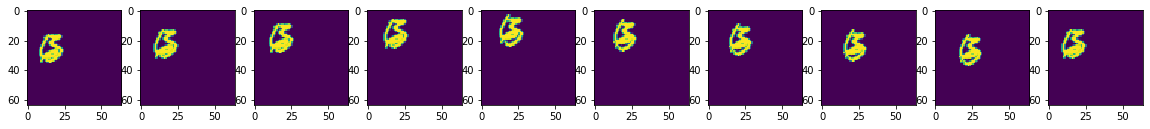

In [3]:
seq, seq_target = next(iter(train_loader))
fig=plt.figure(figsize=(20, 8))

for i in range(1, 11):
    img = seq[0][i-1]
    fig.add_subplot(1, 10, i)
    plt.imshow(img)


print(seq.shape)
plt.imshow( seq[0][1])
